In [1]:
import os
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import os
import sys
import json
from matplotlib.collections import LineCollection
import lmfit

# from clustering_scripts import *

In [2]:
DATADIR = "../data/"
FIGDIR = "../img/"

In [3]:
FROM_I = 10.0
TO_I = 15.0
I_SAMPLES = 11
ANGLE_SAMPLES = 25
RING_SAMPLES_X = 10
RING_SAMPLES_Y = 10

I = np.linspace(FROM_I, TO_I, I_SAMPLES)
angles = np.linspace(0.0, 0.5 * np.pi, ANGLE_SAMPLES)
angles_x = np.linspace(0.0, 2.0 * np.pi, RING_SAMPLES_X)
angles_y = np.linspace(0.0, 2.0 * np.pi, RING_SAMPLES_X)

my_shape = (I_SAMPLES, ANGLE_SAMPLES, RING_SAMPLES_X, RING_SAMPLES_Y)

In [4]:
with h5py.File(os.path.join(DATADIR, "amplitude_3_b1_worst_zeta_avg.h5"), "r") as f:
    x0 = f["reference/initial/x_norm"][:].reshape(my_shape)
    px0 = f["reference/initial/px_norm"][:].reshape(my_shape)
    y0 = f["reference/initial/y_norm"][:].reshape(my_shape)
    py0 = f["reference/initial/py_norm"][:].reshape(my_shape)
    zeta0 = f["reference/initial/zeta_norm"][:].reshape(my_shape)
    pzeta0 = f["reference/initial/pzeta_norm"][:].reshape(my_shape)

    amplitude0 = np.sqrt(x0 ** 2 + px0 ** 2 + y0 ** 2 + py0 ** 2 + zeta0 ** 2 + pzeta0 ** 2)

    times = list(sorted([int(s) for s in f["track/x_norm/"].keys()]))

    x = np.array([f["track/x_norm/{}/".format(t)][:].reshape(my_shape) for t in times])
    px = np.array([f["track/px_norm/{}/".format(t)][:].reshape(my_shape) for t in times])
    y = np.array([f["track/y_norm/{}/".format(t)][:].reshape(my_shape) for t in times])
    py = np.array([f["track/py_norm/{}/".format(t)][:].reshape(my_shape) for t in times])
    zeta = np.array([f["track/zeta_norm/{}/".format(t)][:].reshape(my_shape) for t in times])
    pzeta = np.array([f["track/pzeta_norm/{}/".format(t)][:].reshape(my_shape) for t in times])

    amplitude = np.sqrt(x ** 2 + px ** 2 + y ** 2 + py ** 2 + zeta ** 2 + pzeta ** 2)

In [5]:
with open("/home/HPC/camontan/lhc_paper_indicators/amplitude_tracking/config/particles.json", "r") as f:
    initial_conditions = json.load(f)

with open("/home/HPC/camontan/lhc_paper_indicators/amplitude_tracking/config/appendix.json", "r") as f:
    appendix = json.load(f)

amplitude_x0 = np.asarray(appendix["amplitude_x"]).reshape(my_shape)
amplitude_y0 = np.asarray(appendix["amplitude_y"]).reshape(my_shape)

ValueError: cannot reshape array of size 105000 into shape (11,25,10,10)

In [26]:
np.unique(appendix["amplitude"])

array([10. , 10. , 10. , 10.5, 10.5, 10.5, 11. , 11. , 11. , 11.5, 11.5,
       11.5, 12. , 12. , 12. , 12.5, 12.5, 12.5, 13. , 13. , 13. , 13.5,
       13.5, 13.5, 13.5, 14. , 14. , 14. , 14. , 14.5, 14.5, 14.5, 14.5,
       15. , 15. , 15. , 15. ])

In [49]:
amplitude_mean = np.nanmean(amplitude, axis=(-1,-2))
amplitude0_mean = np.nanmean(amplitude0, axis=(-1,-2))
amplitude_std = np.nanstd(amplitude, axis=(-1,-2))
alive = np.count_nonzero(~np.isnan(amplitude), axis=(-1,-2))


/tmp/ipykernel_11066/1128466083.py:1: RuntimeWarning: Mean of empty slice
  amplitude_mean = np.nanmean(amplitude, axis=(-1,-2))
/home/HPC/camontan/anaconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [50]:
amplitude_std.shape

(188, 11, 25)

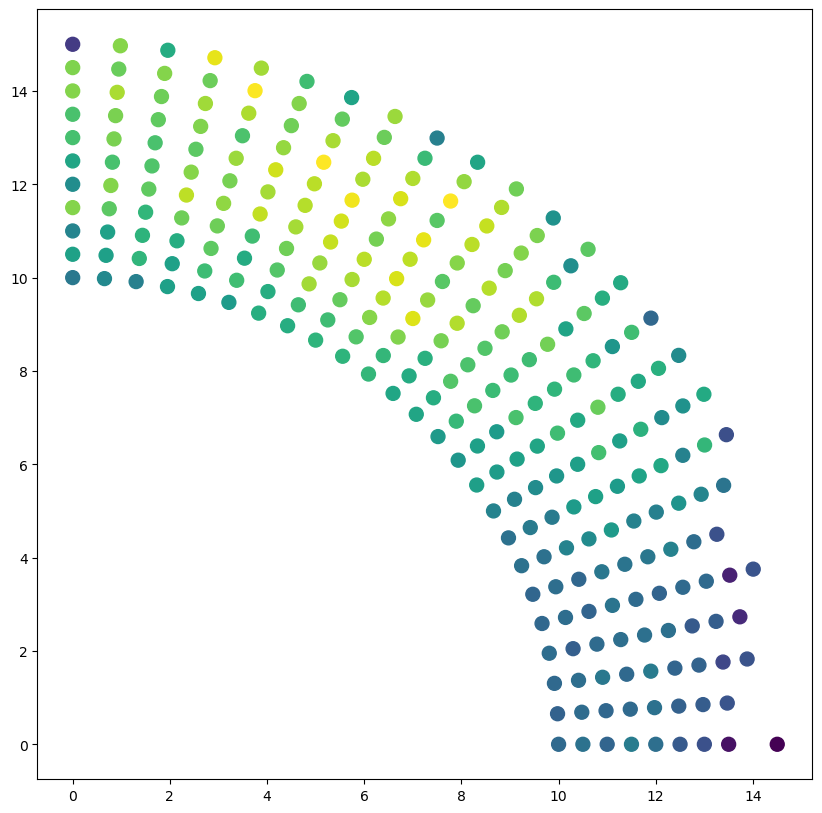

In [51]:
a_std_max = np.nanmax(amplitude_std[-1])
a_std_min = np.nanmin(amplitude_std[-1])

# colormap
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=a_std_min, vmax=a_std_max)

# scatter plot

fig, ax = plt.subplots(figsize=(10, 10))

for i in range(I_SAMPLES):
    ax.scatter(
        amplitude_x0[i,:,0,0],
        amplitude_y0[i,:,0,0],
        c=amplitude_std[-1,i],
        cmap=cmap,
        norm=norm,
        marker="o",
        s=100,
    )

In [59]:
with h5py.File(os.path.join(DATADIR, "rem_b1_worst_zeta_max.h5"), "r") as f:
    times = list(sorted([int(s) for s in f["reverse/x_norm"].keys()]))
    rem = np.array(
        [
            np.power(f[f"reverse/x_norm/{t}"][:] - f["reference/initial/x_norm"][:], 2) +
            np.power(f[f"reverse/y_norm/{t}"][:] - f["reference/initial/y_norm"][:], 2) +
            np.power(f[f"reverse/px_norm/{t}"][:] - f["reference/initial/px_norm"][:], 2) +
            np.power(f[f"reverse/py_norm/{t}"][:] - f["reference/initial/py_norm"][:], 2) +
            np.power(f[f"reverse/zeta_norm/{t}"][:] - f["reference/initial/zeta_norm"][:], 2) +
            np.power(f[f"reverse/pzeta_norm/{t}"][:] - f["reference/initial/pzeta_norm"][:], 2)
            for t in times
        ])
    
with h5py.File(os.path.join(DATADIR, "log_displacement_b1_worst_zeta_max.h5"), "r") as f:
    amplitude = np.sqrt(
        f["reference/initial/x_norm"][:]**2 + f["reference/initial/y_norm"][:]**2
    )

with h5py.File(os.path.join(DATADIR, "stability_b1_worst_zeta_max.h5"), "r") as f:
    stability = f["stability"][:]

DYN_EXTENT = (0.0, 14.5, 0.0, 15.5)

In [60]:
final_rem = np.zeros_like(rem[-1]) * np.nan

for i in range(len(final_rem)):
    # for each particle, find the last rem value that is not nan
    # and set the final_rem value to that
    try:
        final_rem[i] = rem[np.where(~np.isnan(rem[:,i]))[0][-1], i]
    except IndexError:
        final_rem[i] = np.nan

clean_final_rem = final_rem.copy()[stability <= 1e5]
clean_stability = stability.copy()[stability <= 1e5]

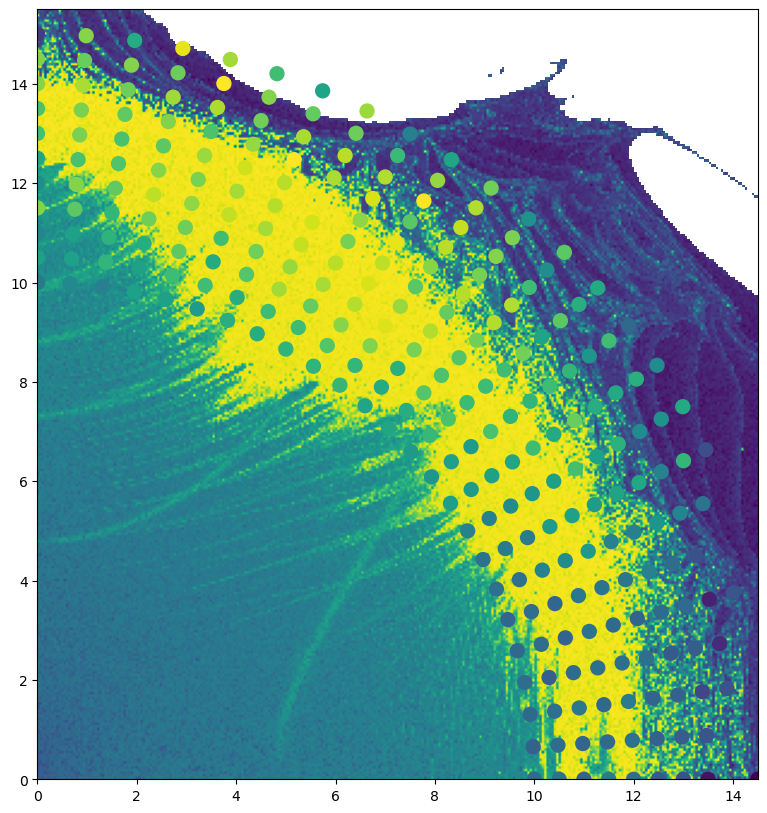

In [62]:
a_std_max = np.nanmax(amplitude_std[-1])
a_std_min = np.nanmin(amplitude_std[-1])

# colormap
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=a_std_min, vmax=a_std_max)

# scatter plot

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(np.log10(final_rem).reshape(300, 300), origin="lower", extent=DYN_EXTENT, cmap="viridis")


for i in range(I_SAMPLES):
    ax.scatter(
        amplitude_x0[i,:,0,0],
        amplitude_y0[i,:,0,0],
        c=amplitude_std[-1,i],
        cmap=cmap,
        norm=norm,
        marker="o",
        s=100,
    )

In [63]:
def power_fit(params, x, data=None):
    a = params["a"].value
    b = params["b"].value
    c = params["c"].value

    model = a + b*np.log10(x)
    model[model > c] = c

    if data is None:
        return 10**model
    
    return model - np.log10(data)


def exp_fit(params, x, data=None):
    a = params["a"].value
    b = params["b"].value
    c = params["c"].value

    model = a + (b * x)
    model[model > c] = c

    if data is None:
        return 10**model
    
    return model - np.log10(data)

In [64]:
out_power = []
out_exp = []

for i in tqdm(range(len(rem[-1]))):
    if np.all(np.isnan(rem[:,i])):
        out_power.append([np.nan, np.nan, np.nan])
        out_exp.append([np.nan, np.nan, np.nan])
        continue
    
    y = rem[20:,i]
    mask = (~np.isnan(y)) & (np.isfinite(y))
    x = np.asarray(times[20:])[mask]
    y = y[mask]
    y /= rem[0, i]

    if np.all(np.isnan(y)) or len(y) < 2:
        out_power.append([np.nan, np.nan, np.nan])
        out_exp.append([np.nan, np.nan, np.nan])
        continue

    lmfit_params = lmfit.Parameters()
    lmfit_params.add("a", value=1)
    lmfit_params.add("b", value=1)
    lmfit_params.add("c", value=23.38413861926543, vary=False)

    lmfit_out_power = lmfit.minimize(power_fit, lmfit_params, args=(x, y))

    lmfit_params = lmfit.Parameters()
    lmfit_params.add("a", value=1)
    lmfit_params.add("b", value=0.001)
    lmfit_params.add("c", value=23.38413861926543, vary=False)

    lmfit_out_exp = lmfit.minimize(exp_fit, lmfit_params, args=(x, y))

    out_power.append([lmfit_out_power.params["a"].value, lmfit_out_power.params["b"].value, lmfit_out_power.redchi])
    out_exp.append([lmfit_out_exp.params["a"].value, lmfit_out_exp.params["b"].value, lmfit_out_exp.redchi])


  0%|          | 0/90000 [00:00<?, ?it/s]

In [66]:
chroma = np.array([
    np.nan if np.isnan(out_power[i][2]) else
    0.0 if out_power[i][2] > out_exp[i][2] else 
    1.0 for i in range(len(out_power))
])

b_power = np.array([out_power[i][1] for i in range(len(out_power))])
b_exp = np.array([out_exp[i][1] for i in range(len(out_exp))])

/tmp/ipykernel_11066/3210033571.py:3: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(b_exp).copy()


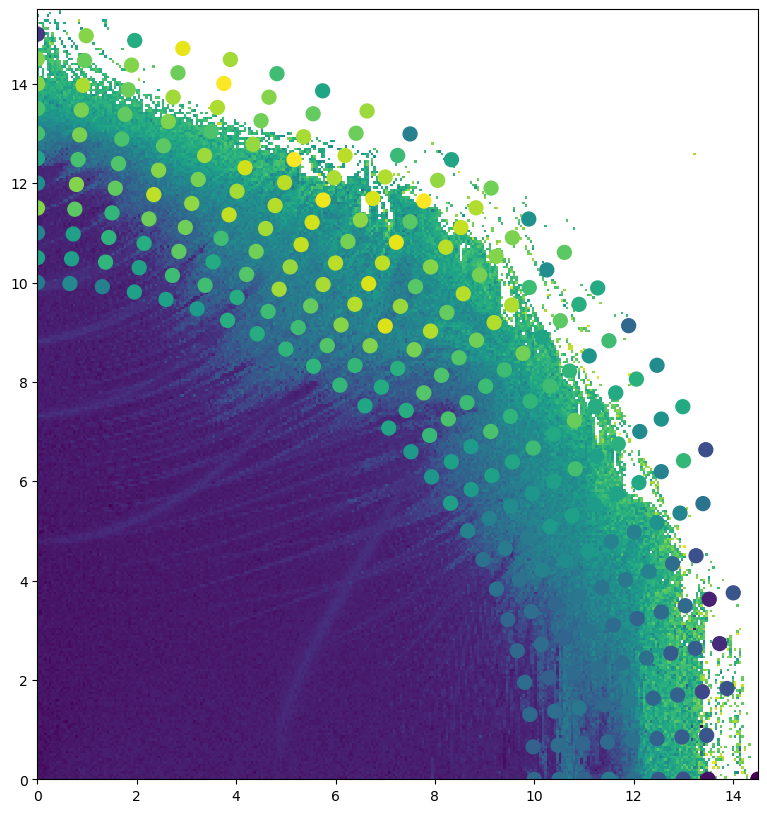

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))

tmp = np.log10(b_exp).copy()
# tmp[chroma != 0] = np.nan
ax.imshow(tmp.reshape(300, 300), origin="lower", interpolation="nearest", extent=DYN_EXTENT, cmap="viridis")

# ax.colorbar()

for i in range(I_SAMPLES):
    ax.scatter(
        amplitude_x0[i,:,0,0],
        amplitude_y0[i,:,0,0],
        c=amplitude_std[-1,i],
        cmap=cmap,
        norm=norm,
        marker="o",
        s=100,
    )

In [79]:
a = [0,1,2,3,4]
b = [5,6,7,8,9]

c = [7,8,9,10,11]

for i, (j,k,l) in enumerate(zip(a,b, c)):
    print(i, j, k, c[i], l)

0 0 5 7 7
1 1 6 8 8
2 2 7 9 9
3 3 8 10 10
4 4 9 11 11


In [77]:
tmp = 0
for i, t in (enumerate(tqdm(range(100000000)))):
    tmp += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

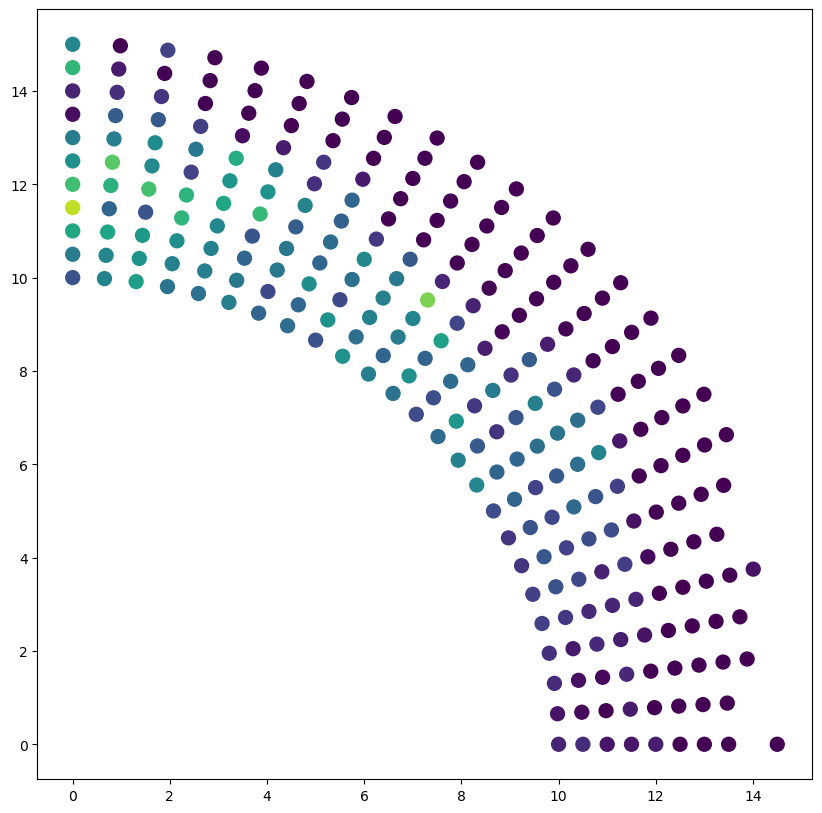

In [52]:
a_mean_max = np.nanmax(amplitude_mean[-1])
a_mean_min = np.nanmin(amplitude_mean[-1])

# colormap
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=1, vmax=1.1)

# scatter plot

fig, ax = plt.subplots(figsize=(10, 10))

for i in range(I_SAMPLES):
    ax.scatter(
        amplitude_x0[i,:,0,0],
        amplitude_y0[i,:,0,0],
        c=amplitude_mean[-1,i]/np.sqrt((amplitude_x0[i,:,0,0]**2 + amplitude_y0[i,:,0,0]**2)),
        cmap=cmap,
        norm=norm,
        marker="o",
        s=100,
    )

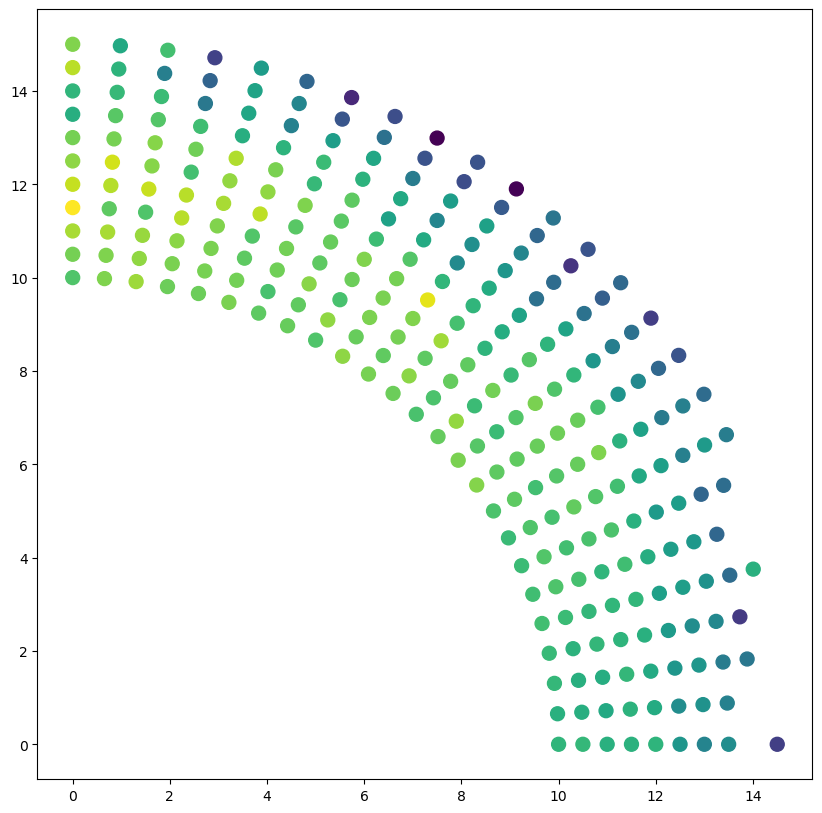

In [53]:
my_amp = amplitude_mean / amplitude0_mean
a_mean_max = np.nanmax(my_amp[-1])
a_mean_min = np.nanmin(my_amp[-1])

# colormap
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=a_mean_min, vmax=a_mean_max)

# scatter plot

fig, ax = plt.subplots(figsize=(10, 10))

for i in range(I_SAMPLES):
    ax.scatter(
        amplitude_x0[i,:,0,0],
        amplitude_y0[i,:,0,0],
        c=my_amp[-1,i],
        cmap=cmap,
        norm=norm,
        marker="o",
        s=100,
    )

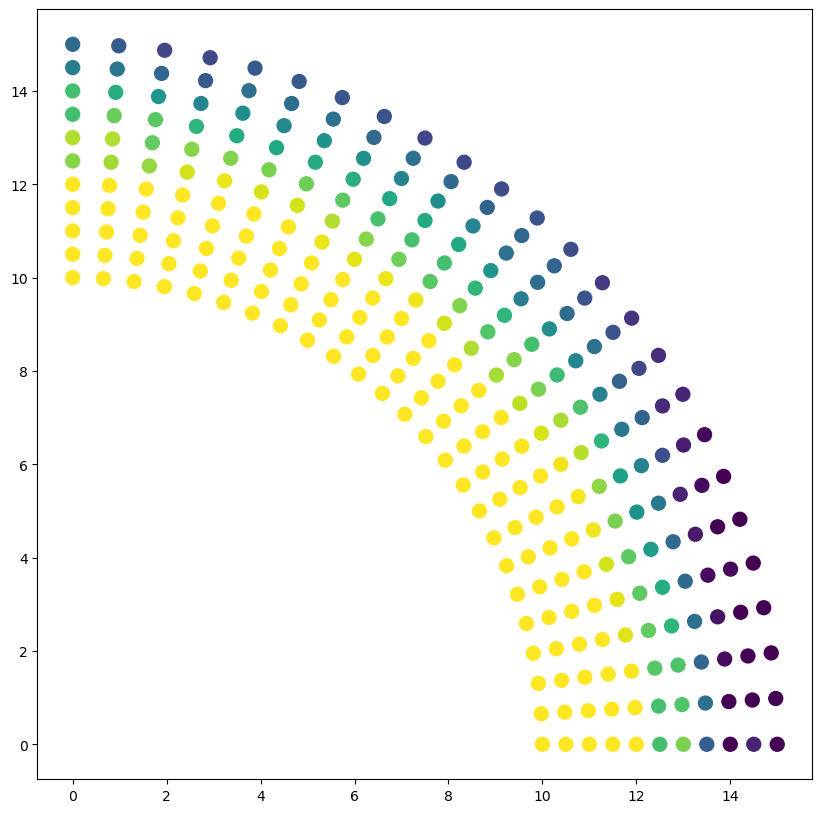

In [57]:
my_val = alive
a_mean_max = np.nanmax(my_val[-1])
a_mean_min = np.nanmin(my_val[-1])

# colormap
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=a_mean_min, vmax=a_mean_max)

# scatter plot

fig, ax = plt.subplots(figsize=(10, 10))

for i in range(I_SAMPLES):
    ax.scatter(
        amplitude_x0[i,:,0,0],
        amplitude_y0[i,:,0,0],
        c=my_val[-1,i],
        cmap=cmap,
        norm=norm,
        marker="o",
        s=100,
    )